In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#from adjustText import adjust_text
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm, colors
from scipy.stats import pearsonr

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Load data

In [4]:
# load data
Task1_filtered = pd.read_csv('data/Task1_Final.csv')
trait_all = pd.read_csv('data/Trait_Final.csv')
Task1_filtered['prop_Help'] = (Task1_filtered[[f'Q{i}' for i in range(1,101)]] > 0).sum(axis=1)/Task1_filtered['ValidS']
scenario_summary = pd.read_csv('output/Task1_scenario_summary.csv',index_col=0)
Task2_ratings = pd.read_csv('output/Task2_scenario_ratings_AC_Var_Mean.csv',index_col=0)
WTH_mot = pd.read_csv('output/WTH_motivation_decomposition.csv',index_col=0)
# parameter recovery
param_rec_df = pd.read_csv('output/Model/VBD_M3/param_recovery_sampledparam.csv')

In [6]:
# check the prediction accuracy of scenarios
model_fit_m3 = pd.read_csv('output/Model/VBD_M3/model_fits.csv')
pred_allsub_df_m3 = pd.read_csv('output/Model/VBD_M3/LOO_pred.csv')

In [7]:
data_3spec = pd.read_csv('output/data_three_spaces.csv',index_col = 0) # this spreadsheet is updated with the finalized scenario descriptions
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data_3spec['Semantic_label'])
data_3spec['label_numeric'] = label_encoded

# Figure 2: Rating overview

## 2a: mean WTH ratings in descending order

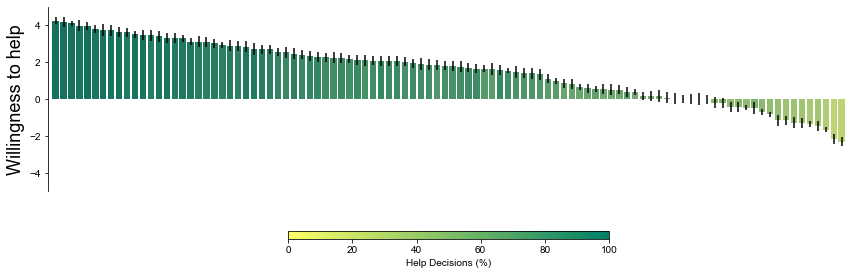

In [6]:
# Rank scenarios
sorted_rating = scenario_summary.sort_values(by='mean',ascending=False)

# set the colors
norm = colors.Normalize(vmin=0, vmax=100)
cmap = cm.summer_r  # Choose the color map
bar_colors = cmap(sorted_rating['help_prop'])

# make plot
plt.figure(figsize=(12, 4))
plt.rcParams['font.family'] = 'Arial'
ax = sns.barplot(data=sorted_rating, x=sorted_rating.index, y="mean",palette=bar_colors)
ax.errorbar(range(100), sorted_rating['mean'], sorted_rating['SD']/np.sqrt(scenario_summary['n']),lw=1.5, fmt = 'none',color="black")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

cbar = ax.figure.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15, aspect=40, shrink=0.4)
cbar.set_label('Help Decisions (%)')
cbar.ax.yaxis.set_label_position('right')
ax.set_ylabel('Willingness to help', size=18)
ax.set_xlabel('')
ax.set_xticks([])

plt.ylim(-5,5)
ax.set_xlim([-1,100])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
print(sorted_rating.index[99])

Q4


## 2b: distribution of WTH 

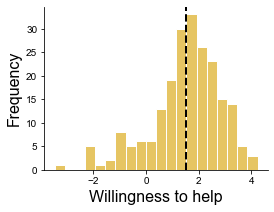

In [8]:
# Average willingness rating
plt.figure(figsize=(4,3))
plt.rcParams['font.family'] = 'Arial'

plt.hist(Task1_filtered['Mean'],bins=20,facecolor = '#e6c563',edgecolor = 'white')
plt.xlabel('Willingness to help',size=16)
plt.axvline(Task1_filtered['Mean'].mean(),color='black',ls='--',lw=2)
plt.ylabel('Frequency', size=16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
#print(f"Mean = {Task1_filtered['Mean'].mean()}")
#print(f"SD = {Task1_filtered['Mean'].std()}")

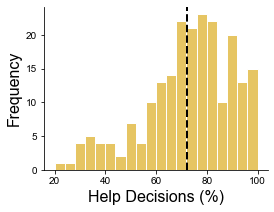

In [9]:
# Binarized helping propensity
plt.figure(figsize=(4,3))
plt.rcParams['font.family'] = 'Arial'

plt.hist(Task1_filtered['prop_Help']*100,bins=20,facecolor = '#e6c563',edgecolor = 'white')
plt.xlabel('Help Decisions (%)',size=16)
plt.axvline(Task1_filtered['prop_Help'].mean()*100,color='black',ls='--',lw=2)
plt.ylabel('Frequency', size=16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
#print(f"Mean = {Task1_filtered['prop_Help'].mean()}")
#print(f"SD = {Task1_filtered['prop_Help'].std()}")

## 2c: heatmap of scenario ratings

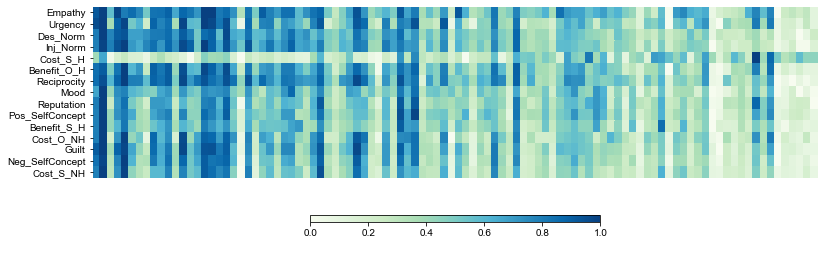

In [10]:
rating_df = Task2_ratings.drop(columns = 'Other').astype('float')
# sort by the mean WTH rating
rating_df['WTH'] = scenario_summary['mean'].values
sorted_task2_ratings = rating_df.sort_values(by='WTH',ascending=False)
sorted_task2_ratings = sorted_task2_ratings.drop(columns = 'WTH')
rating_df_normalized = (sorted_task2_ratings - sorted_task2_ratings.min()) / (sorted_task2_ratings.max() - sorted_task2_ratings.min())

# plot
fig,ax = plt.subplots(figsize = (13,4.5))
plt.rcParams['font.family'] = 'Arial'
sns.heatmap(rating_df_normalized.T, cmap = 'GnBu',annot=False, cbar=False, cbar_kws={'orientation':'horizontal','shrink':0.5}, ax= ax)
ax.set_xticks([])

# set the colors
norm = colors.Normalize(vmin=0, vmax=1)
cmap = cm.GnBu  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = ax.figure.colorbar(sm, ax=ax,orientation='horizontal', pad=0.15, aspect=40, shrink=0.4)
cbar.set_label(' ')


# Supp Fig 2

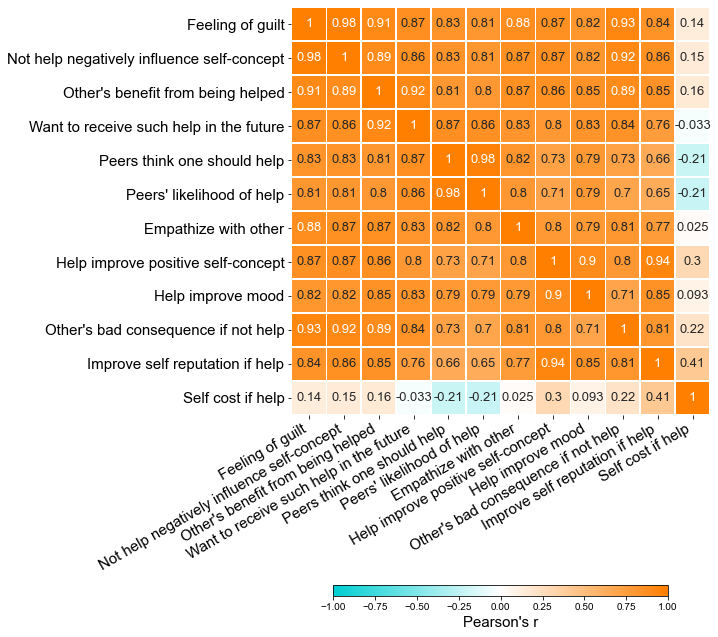

In [44]:
import matplotlib.colors as mcolors

varlist = ['Guilt','Neg_SelfConcept','Benefit_O_H','Reciprocity','Inj_Norm','Des_Norm',
            'Empathy','Pos_SelfConcept','Mood','Cost_O_NH','Reputation','Cost_S_H']
labellist = ['Feeling of guilt','Not help negatively influence self-concept','Other\'s benefit from being helped',
           'Want to receive such help in the future','Peers think one should help','Peers\' likelihood of help',
            'Empathize with other','Help improve positive self-concept','Help improve mood',
           'Other\'s bad consequence if not help','Improve self reputation if help','Self cost if help']
plt.figure(figsize=(7.5,12.5))
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#00CED1", "white", "#FF7F00"])
ax = sns.heatmap(rating_df_normalized[varlist].corr(), cmap=cmap,vmin=-1,vmax=1,
                 annot=True,cbar=False,linecolor='white',lw=0.5,annot_kws={"fontsize": 13})
ax.set_xticklabels(labellist, rotation=30, ha="right", fontsize=15)  # Rotate if needed
ax.set_yticklabels(labellist, rotation=0, fontsize=15)

# set the colors
norm = colors.Normalize(vmin=-1, vmax=1)
#cmap = cm.coolwarm  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = ax.figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.25, aspect=30, shrink=0.8)
cbar.set_label('Pearson\'s r',fontsize=15)

plt.savefig("output/Figures/Fig_S2a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()



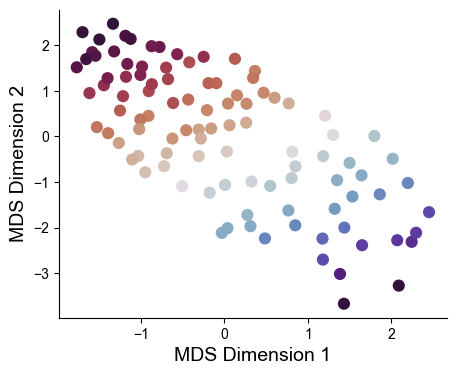

In [99]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(data_3spec['Decision_x'],data_3spec['Decision_y'],c=data_3spec['WTH'],cmap="twilight_shifted",s=60)
ax.set_xlabel('MDS Dimension 1',size=14)
ax.set_ylabel('MDS Dimension 2',size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

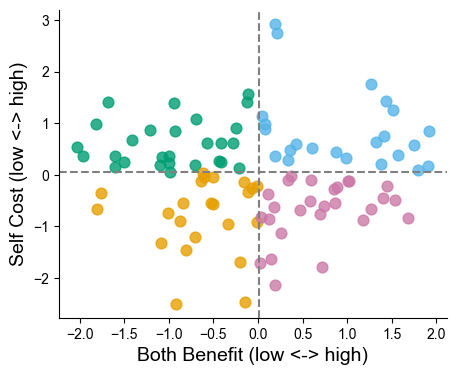

In [111]:
med_reward = 0.0147062271753168
med_cost = 0.05109126821364465

col_list = ["#009e73", "#56b4e9", "#e69f00","#cc79a7"]
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,4))
for q in [1,2,3,4]:
    mask = data_3spec['Motivation_label'] == q
    ax.scatter(data_3spec['Motivation_reward'].loc[mask],data_3spec['Motivation_cost'].loc[mask],color=col_list[q-1],s=60,alpha=0.8)
ax.set_xlabel('Both Benefit (low <-> high)',size=14)
ax.set_ylabel('Self Cost (low <-> high)',size=14)
ax.axvline(med_reward,color='gray',ls='--') # median
ax.axhline(y=med_cost,color='gray',ls='--') # median
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

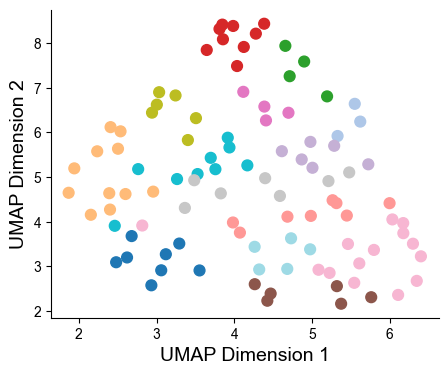

In [44]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(data_3spec['Semantic_x'],data_3spec['Semantic_y'],c=data_3spec['label_numeric'],cmap="tab20",s=60)
ax.set_xlabel('UMAP Dimension 1',size=14)
ax.set_ylabel('UMAP Dimension 2',size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Figure 4: Associations among three spaces

## 4a: Motivation space vs. Decision space

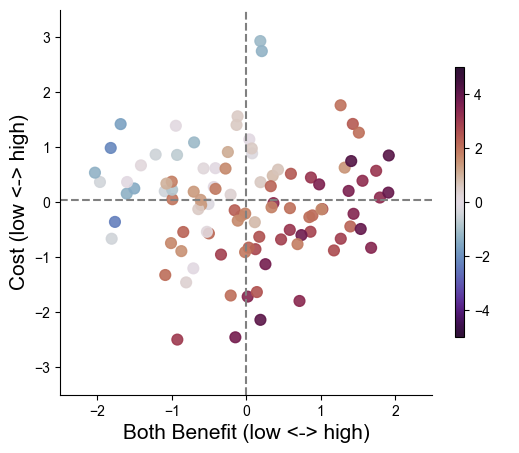

In [74]:
# color the motivation space with WTH ratings
med_reward = data_3spec['Motivation_reward'].median()
med_cost = data_3spec['Motivation_cost'].median()

plt.figure(figsize=(6,5))
plt.rcParams['font.family'] = 'Arial'
plt.axvline(x=med_reward,color='gray',ls='--')
plt.axhline(y=med_cost,color='gray',ls='--')
plt.scatter(data_3spec['Motivation_reward'],data_3spec['Motivation_cost'],c=data_3spec['WTH'],s =60, vmin=-5,vmax=5,cmap="twilight_shifted",alpha=0.9)
plt.xlabel('Both Benefit (low <-> high)',size=15)
plt.ylabel('Cost (low <-> high)',size=15)
plt.xlim([-2.5,2.5])
plt.ylim([-3.5,3.5])

# set the colors
norm = colors.Normalize(vmin=-5, vmax=5)
cmap = cm.twilight_shifted  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label(' ')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Figure S4a: quadrant comparison

In [10]:
summary_4q = data_3spec.groupby('Motivation_label').agg(
    mean_value=('WTH', 'mean'),
    sample_size=('WTH', 'size'),
    std_dev=('WTH', 'std')
).reset_index()
summary_4q

,Motivation_label,mean_value,sample_size,std_dev
0,1,0.025540,27,1.150892
1,2,1.964774,23,1.680898
2,3,1.373986,23,1.331628
3,4,2.768993,27,0.796160


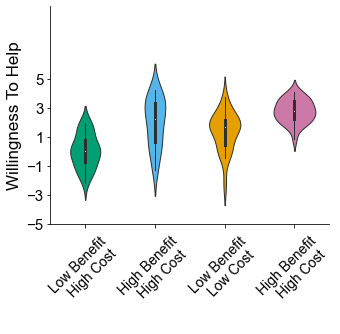

In [49]:
# Statistical analysis 1: comparison across 4 quadrants:
# customize colors
quadrant_cols = {1:"#009e73",2:"#56b4e9",3:"#e69f00",4:"#cc79a7"}
plt.figure(figsize=(5,4))
sns.violinplot(data=data_3spec, x="Motivation_label", y="WTH", palette = quadrant_cols,width=0.6, saturation=1, linewidth=1)
plt.ylabel('Willingness To Help',size=17)
plt.xlabel(' ',size=15)
plt.yticks([-5,-3,-1,1,3,5],size=15)
plt.ylim(-5,10)
plt.gca().set_xticklabels(['Low Benefit \n High Cost','High Benefit \n High Cost','Low Benefit \n Low Cost','High Benefit \n High Cost'], rotation=45, ha='center', size = 14) 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [36]:
model = ols('WTH ~ C(Motivation_label)', data=data_3spec).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

tukey = pairwise_tukeyhsd(endog=data_3spec['WTH'], groups=data_3spec['Motivation_label'], alpha=0.05)
print(tukey)

                         sum_sq    df          F        PR(>F)
C(Motivation_label)  107.461377   3.0  22.610153  3.708338e-11
Residual             152.089375  96.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   1.9392    0.0  1.0054  2.873   True
     1      3   1.3484 0.0016  0.4146 2.2823   True
     1      4   2.7435    0.0  1.8478 3.6391   True
     2      3  -0.5908 0.3882 -1.5612 0.3797  False
     2      4   0.8042 0.1169 -0.1296  1.738  False
     3      4    1.395  0.001  0.4612 2.3288   True
---------------------------------------------------


## S4bc: Cost and benefit ~ WTH

In [47]:
from scipy import stats
import pingouin as pg
corr_WTH_benefit = stats.pearsonr(data_3spec['WTH'], data_3spec['Motivation_reward'])
ci_benefit = pg.compute_bootci(data_3spec['WTH'], data_3spec['Motivation_reward'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
corr_WTH_cost = stats.pearsonr(data_3spec['WTH'], data_3spec['Motivation_cost'])
ci_cost = pg.compute_bootci(data_3spec['WTH'], data_3spec['Motivation_cost'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)

In [49]:
ci_cost

array([-0.6014, -0.2993])

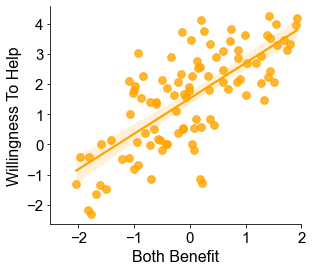

In [67]:
plt.figure(figsize=(4.5,4))
plt.rcParams['font.family'] = 'Arial'
sns.regplot(x = data_3spec['Motivation_reward'], y = data_3spec['WTH'], color = 'orange', scatter_kws={'s':60})
plt.xlabel('Both Benefit',size=16)
plt.ylabel('Willingness To Help',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-2.5,2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

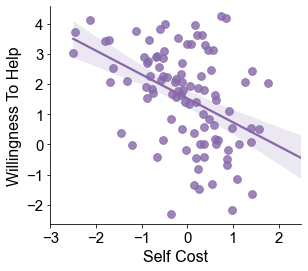

In [68]:
plt.figure(figsize=(4.5,4))
plt.rcParams['font.family'] = 'Arial'
sns.regplot(x = data_3spec['Motivation_cost'], y = data_3spec['WTH'], color = '#8668aa', scatter_kws={'s':60})
plt.xlabel('Self Cost',size=16)
plt.ylabel('Willingness To Help',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-3,2.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## S4def: Semantic space

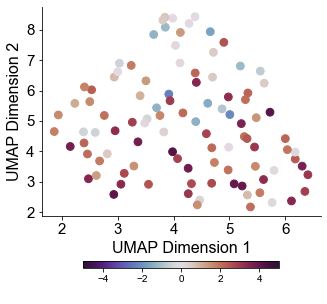

In [70]:
# S4d: color by WTH
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,5.5))
ax.scatter(data_3spec['Semantic_x'],data_3spec['Semantic_y'],c=data_3spec['WTH'],cmap="twilight_shifted",vmin=-5, vmax=5,s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the colors
norm = colors.Normalize(vmin=-5, vmax=5)
cmap = cm.twilight_shifted  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')

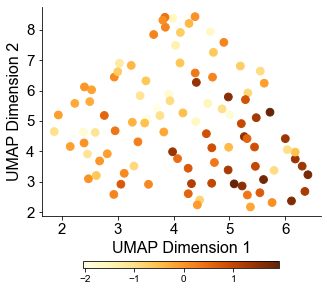

In [74]:
# S4e: color by benefit
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,5.5))
ax.scatter(data_3spec['Semantic_x'],data_3spec['Semantic_y'],c=data_3spec['Motivation_reward'],cmap="YlOrBr",s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = colors.Normalize(vmin=data_3spec['Motivation_reward'].min(), vmax=data_3spec['Motivation_reward'].max())
cmap = cm.YlOrBr  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')

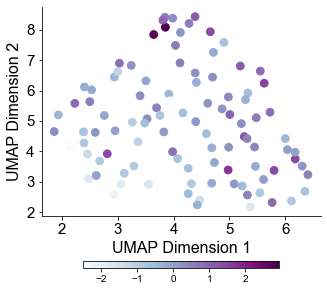

In [75]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,5.5))
ax.scatter(data_3spec['Semantic_x'],data_3spec['Semantic_y'],c=data_3spec['Motivation_cost'],cmap="BuPu",s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = colors.Normalize(vmin=data_3spec['Motivation_cost'].min(), vmax=data_3spec['Motivation_cost'].max())
cmap = cm.BuPu  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')

## 4b: Decision space vs. Semantic space

In [8]:
data_3spec.loc[data_3spec['Semantic_label'] == 'Safety',:]

,Scenario,Action,Label,Decision_x,Decision_y,WTH,Motivation_reward,Motivation_cost,Motivation_label,Semantic_x,Semantic_y,Semantic_label,label_numeric
S2,"Sunday, 1am - You were having a very nice drin...","To help the drunk man, someone needs to stay h...",report a drunk person,1.349625,-0.961086,0.067961,-0.944945,1.390401,1,5.796814,3.370692,Safety,9
S9,"It is a very humid summer day, you are heading...",The person needs someone to move them to a sha...,help a faint person,-1.175618,1.306490,3.111628,1.747313,0.571437,2,6.401492,3.227322,Safety,9
S17,You are camping at a popular campsite. While p...,The hungry camper wants someone to share some ...,share food with hungry camper,0.009351,-1.064643,0.551402,-0.129125,1.405253,1,2.815680,3.916761,Safety,9
S32,"While shopping in a large supermarket, the fir...","To save the freezing person, someone needs to ...",fire evacuation,-0.095008,1.166582,2.417476,1.433511,1.423420,2,6.175271,3.745153,Safety,9
S33,"Sitting in a coffee shop, you watch the outsid...",It would help protect other pedestrians if som...,report a harmful person,1.533290,-1.318565,-0.190698,-0.505883,-0.032608,3,6.173807,3.971379,Safety,9
S36,Morning rushing hour. While driving on the fre...,It would be helpful for all the road users if ...,report overdose driver,0.601517,0.847555,1.843137,0.690477,-0.762140,4,5.543478,2.634386,Safety,9
S37,"Hot summer day, you are driving passing a resi...",To stop the fire and avoid the residents' lost...,notify garbage fire,-0.866617,1.143591,2.940594,1.271743,-0.663909,4,6.347967,2.677632,Safety,9
S42,"Walking in a city street, you saw a person lyi...",The victim needs someone to move them to the s...,"person being hit, call ambulance",-0.563278,1.801612,3.316832,1.797805,0.085199,2,5.608574,3.069277,Safety,9
S47,"Reading a book near your bedroom window, you h...",It would be helpful if a nearby resident can b...,clean broken glass,-0.620928,-0.047962,1.941176,-0.991380,0.054435,1,6.034392,4.052906,Safety,9
S55,"On a heavily snowy day, you finish work and ca...",The patient wants a ride to the nearest hospit...,give a hospital ride on a snowy day,-1.102078,-0.506288,1.640777,1.012258,-0.128325,4,5.462588,3.503951,Safety,9


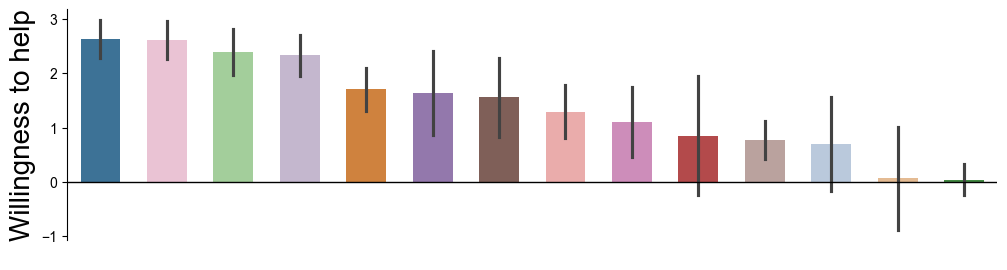

In [9]:
# whether there are diff. in the overall ratings across different semantic categories
order = data_3spec.groupby('Semantic_label')['WTH'].mean().sort_values(ascending = False).index

# visualize the differences
plt.figure(figsize=(12,3))
plt.rcParams['font.family'] = 'Arial'
sns.barplot(data=data_3spec, x="Semantic_label", y="WTH",hue = "label_numeric",errorbar = "se", order = order,
            palette = "tab20",width=0.6, saturation=0.6, linewidth=1, legend = False)
plt.ylabel('Willingness to help',size=20)
plt.gca().set_xticks([])
plt.xlabel(' ')
plt.axhline(0,color='black',lw=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

## 4c: Motivation space vs. Semantic space

/var/folders/q3/p97t_szn2839pg93wqkzdj0c0000gn/T/ipykernel_54203/2208627945.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha='right', size = 18)


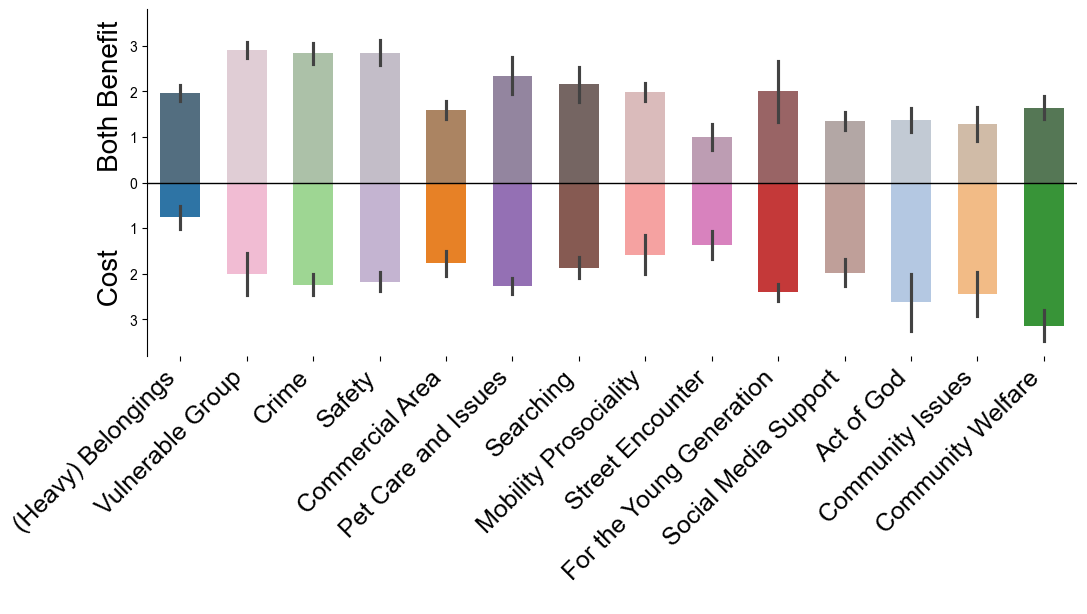

In [12]:
# Benefit and Cost in the semantic space

data_3spec['Reward_transformed'] = data_3spec['Motivation_reward'] + 2
data_3spec['Cost_transformed'] = -(data_3spec['Motivation_cost'] + 2)

plt.rcParams['font.family'] = 'Arial'
fig,ax = plt.subplots(figsize=(12,4.5))
sns.barplot(data=data_3spec, x="Semantic_label", y="Reward_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.3, linewidth=1, legend = False, ax = ax)
ax.set_ylim([-3.8,3.8])
ax.set_ylabel('     Cost          Both Benefit',size = 20)
ax.set_xticklabels(order, rotation=45, ha='right', size = 18)
ax.set_xlabel(' ')
ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax.set_yticklabels([3, 2, 1, 0, 1, 2, 3])  # Reverse the labels
plt.axhline(0,color="black",lw=1)

sns.barplot(data=data_3spec, x="Semantic_label", y="Cost_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.8, linewidth=1, legend = False, ax = ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

# Figure 5. Model Helping Decisions

## 5a: the softmax

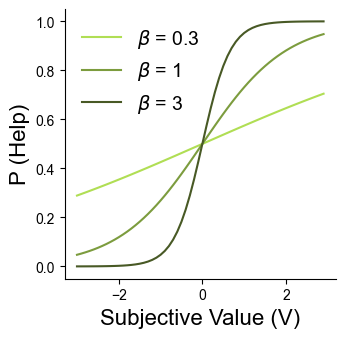

In [266]:
x = np.arange(-3,3,0.1)
beta_list = [0.3, 1, 3]
color_list  = ['#b0de54','#7c9c3e','#485925']

plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(3.5,3.5))
for beta,col in zip(beta_list,color_list):
    y = 1/(1+np.exp(-beta*x))
    plt.plot(x,y, label = r'$\beta$ = '+ f'{beta}',color=col )
plt.xlabel('Subjective Value (V)',size=16)
plt.ylabel('P (Help)',size=16)
plt.legend(frameon=False, fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## 5b: model comparison

In [7]:
def extract_diagnostics(model_list,metric,n_param):
    summary_all = None
    for mname,k in zip(model_list,n_param): 
        model_m = pd.read_csv('output/Model/'+mname+'/model_fits.csv')
        # revise AIC, BIC
   #     model_m['AIC'] = 2*k + 2*model_m['neg_llh']
   #     model_m['BIC'] = np.log(50)*k + 2*model_m['neg_llh']
        model_m[mname] = model_m[metric]
        if summary_all is None:
            summary_all = model_m[['ID',mname]]
        else:
            summary_all = summary_all.merge(model_m[['ID',mname]],on = 'ID')
    return summary_all

C:\Users\v0409128\AppData\Local\Temp\ipykernel_17236\2061719429.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=30, ha='right', size = 15)


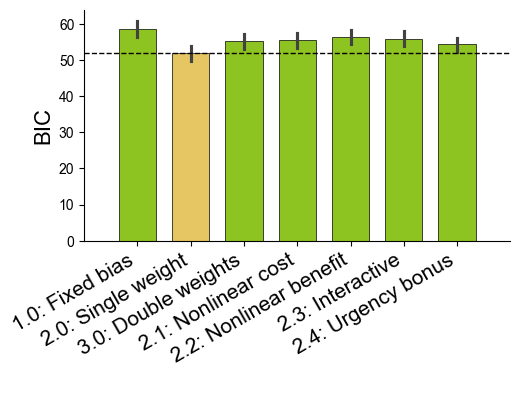

In [9]:
model_list = ['VBD_M5','VBD_M3','VBD_M3_1','VBD_M3_2','VBD_M3_3','VBD_M4','VBD_M3_4']
n_param = [2, 3, 4, 4, 4, 4, 4]
BIC_all = extract_diagnostics(model_list,'BIC',n_param)
BIC_melted = r2_all.melt(var_name='Model', value_name='BIC', id_vars='ID')

model_names = ['1.0: Fixed bias','2.0: Single weight','3.0: Double weights','2.1: Nonlinear cost','2.2: Nonlinear benefit','2.3: Interactive','2.4: Urgency bonus']

plt.rcParams['font.family'] = 'Arial'
fig,ax = plt.subplots(figsize=(5.5,3))
sns.barplot(BIC_melted, x="Model", y="BIC",ax=ax, width=0.7, edgecolor = 'black', lw=0.5, facecolor = '#8ec421', saturation=1)
ax.patches[1].set_facecolor('#e6c563')  # Change the second bar's color to red
ax.set_xticklabels(model_names, rotation=30, ha='right', size = 15)
ax.set_xlabel(' ')
ax.set_ylabel('BIC',size=16)
ax.set_xlim([-1,7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(r2_all['VBD_M3'].mean(),ls='--',lw=1,color='black')
plt.show()

## 5c: w_cost ~ (Low - high) cost WTH

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\v0409128\AppData\Local\Temp\ipykernel_29624\3000609408.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)


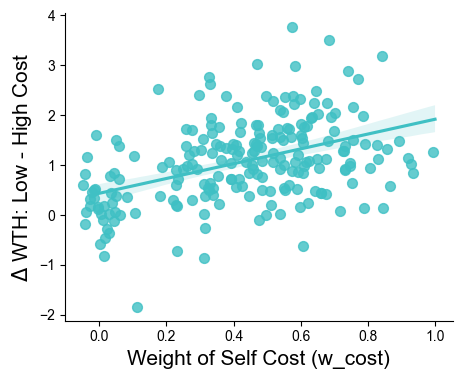

In [63]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5,4))
sns.regplot(x = model_fit_m3['w_cost'], y = WTH_mot['Low-High_Cost'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':50})
#plt.scatter(model_fit_m3['w_cost'],WTH_mot['Low-High_Cost'],alpha = 0.7,s=60, color = '#3fc0c4')
plt.xlabel('Weight of Self Cost (w_cost)',size=15)
plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)
#plt.yticks([-1,-0.5,0,0.5,1])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [60]:
r_wcost_lowhighcost,p_wcost_lowhighcost = pearsonr(model_fit_m3['w_cost'],WTH_mot['Low-High_Cost'])
ci_wcost_lowhighcost = pg.compute_bootci(model_fit_m3['w_cost'],WTH_mot['Low-High_Cost'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_wcost_lowhighcost,p_wcost_lowhighcost,ci_wcost_lowhighcost

(0.4324226702285944, 3.2976066455672625e-11, array([0.3172, 0.517 ]))

## 5d: w_cost ~ (Low - high) cost WTH

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\v0409128\AppData\Local\Temp\ipykernel_29624\2747664649.py:5: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)


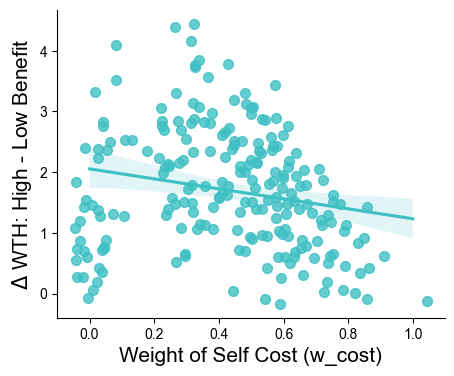

In [64]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5,4))
sns.regplot(x = model_fit_m3['w_cost'], y = WTH_mot['High-Low_Benefit'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':50})
plt.xlabel('Weight of Self Cost (w_cost)',size=15)
plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)
#plt.yticks([-1,-0.5,0,0.5,1])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [65]:
r_wcost_highlowbenefit,p_wcost_highlowbenefit = pearsonr(model_fit_m3['w_cost'],WTH_mot['High-Low_Benefit'])
ci_wcost_highlowbenefit = pg.compute_bootci(model_fit_m3['w_cost'],WTH_mot['High-Low_Benefit'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_wcost_highlowbenefit,p_wcost_highlowbenefit,ci_wcost_highlowbenefit

(-0.20384251469317627, 0.002672543867628937, array([-0.3366, -0.064 ]))

## 5e: b ~ WTH

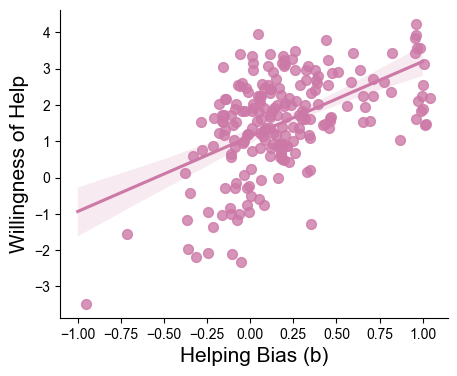

In [67]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5,4))
sns.regplot(x = -model_fit_m3['b'], y = Task1_filtered['Mean'], color = '#cc79a7', x_jitter=0.05, scatter_kws={'s':50})
plt.xlabel('Helping Bias (b)',size=15)
plt.ylabel('Willingness of Help',size=15)
#plt.yticks([-1,-0.5,0,0.5,1])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [69]:
r_b_WTH,p_b_WTH = pearsonr(-model_fit_m3['b'], Task1_filtered['Mean'])
ci_b_WTH = pg.compute_bootci(-model_fit_m3['b'], Task1_filtered['Mean'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_b_WTH,p_b_WTH,ci_b_WTH

(0.5221557236911113, 1.9502971266345249e-16, array([0.4099, 0.6191]))

## 5f: prediction performance

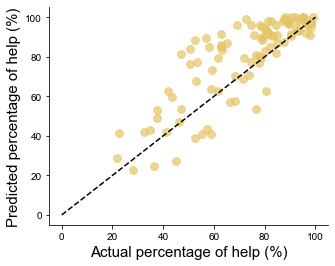

In [6]:
scenario_pred = pred_allsub_df_m3.groupby('Scenario')[['Decision','Pred_choice']].mean()
scenario_pred = scenario_pred.merge(data_3spec, left_on='Scenario', right_index = True)
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5,4))
plt.plot([0,100],[0,100],color='black',ls='--')
plt.scatter(scenario_pred['Decision']*100,scenario_pred['Pred_choice']*100,alpha = 0.7,s=60, color= '#e6c563') # c=scenario_pred['label_numeric'],cmap="tab20")
plt.xlabel('Actual percentage of help (%)',size=15)
plt.ylabel('Predicted percentage of help (%)',size=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [72]:
np.corrcoef(scenario_pred['Decision'],scenario_pred['Pred_choice'])[0,1]

r_perc_pred,p_perc_pred = pearsonr(scenario_pred['Decision'], scenario_pred['Pred_choice'])
ci_perc_pred = pg.compute_bootci(scenario_pred['Decision'],scenario_pred['Pred_choice'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_perc_pred,p_perc_pred,ci_perc_pred

(0.8242366149071073, 6.047973847643647e-26, array([0.7463, 0.8799]))

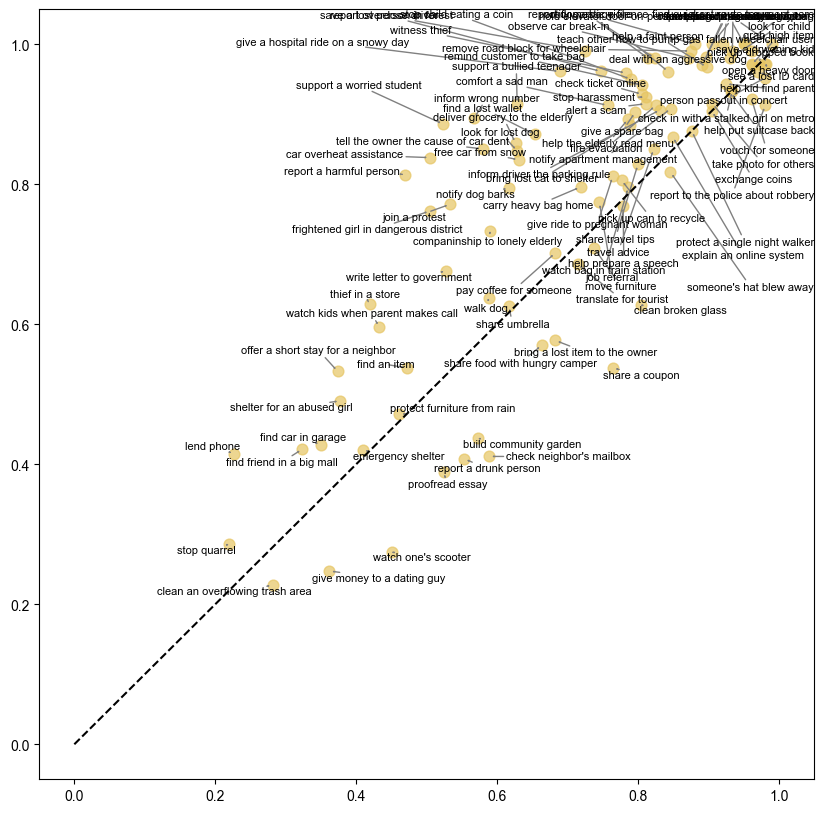

In [238]:
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],color='black',ls='--')
plt.scatter(scenario_pred['Decision'],scenario_pred['Pred_choice'],alpha = 0.7,s=60, color= '#e6c563') # c=scenario_pred['label_numeric'],cmap="tab20")
texts = [plt.text(sample['Decision'],sample['Pred_choice'],sample['Label'],ha='center',va='center',size=8) for row,sample in scenario_pred.iterrows()]
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

In [7]:
# whether the deviation of the prediction is associated with the number of extra motivations people reported
scenario_pred['Deviation'] = scenario_pred['Decision'] - scenario_pred['Pred_choice']
# reorganize the openended response spreadsheet
text_convert = pd.read_csv('output/Open_ended/Open_ended_response_labeled.csv',index_col = 0)
text_convert = text_convert.loc[text_convert['New']==1,:]
label_count = text_convert['No.'].value_counts().reset_index()
label_count.columns = ['Label','Count']
label_count.set_index('Label',inplace=True)
# merge the two 
scenario_pred = scenario_pred.merge(label_count, how = 'left',left_index= True, right_index = True)
scenario_pred['Count'] = scenario_pred['Count'].fillna(0)

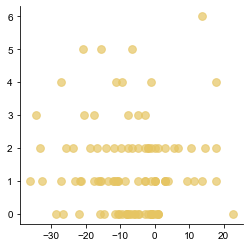

In [8]:
# check the correlation
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4,4))
plt.scatter(scenario_pred['Deviation']*100,scenario_pred['Count'],alpha = 0.7,s=60, color= '#e6c563') # c=scenario_pred['label_numeric'],cmap="tab20")
#plt.xlabel('Actual percentage of help (%)',size=15)
#plt.ylabel('Predicted percentage of help (%)',size=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [9]:
np.corrcoef(scenario_pred['Deviation']*100,scenario_pred['Count'])

array([[ 1.       , -0.0225552],
       [-0.0225552,  1.       ]])

## OLD 5d: w_cost ~ b

In [129]:
model_fit_m3 = model_fit_m3.merge(Task1_filtered, left_on = 'ID', right_on = 'PROLIFIC_PID')

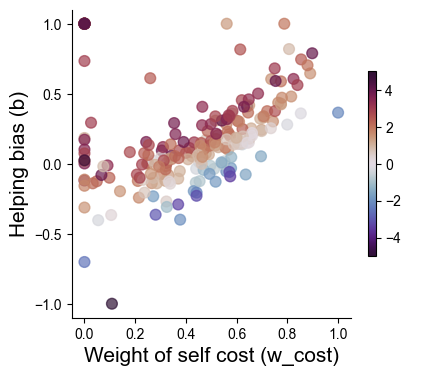

In [184]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4.5,4))
plt.scatter(model_fit_m3['w_cost'],-model_fit_m3['b'],alpha = 0.7,s=60, c=model_fit_m3['Mean'],cmap="twilight_shifted")
plt.xlabel('Weight of self cost (w_cost)',size=15)
plt.ylabel('Helping bias (b)',size=15)
plt.yticks([-1,-0.5,0,0.5,1])

# set the colors
norm = colors.Normalize(vmin=-5, vmax=5)
cmap = cm.twilight_shifted  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='vertical', pad=0.05, aspect=25, shrink=0.6)
cbar.set_label(' ')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [141]:
np.corrcoef(model_fit_m3['w_cost'],model_fit_m3['b'])[0,1]

-0.15439319083409714

# Supp Table 3: Model Comparison

In [19]:
model_list = ['VBD_M5','VBD_M3','VBD_M3_1','VBD_M3_2','VBD_M3_3','VBD_M4','VBD_M3_4']
n_param = [2, 3, 4, 4, 4, 4, 4]
model_diagnostics = None
r2_all = extract_diagnostics(model_list,'r2',n_param)
AIC_all = extract_diagnostics(model_list,'AIC',n_param)
BIC_all = extract_diagnostics(model_list,'BIC',n_param)
LOOACC_all = extract_diagnostics(model_list,'test_acc',n_param)
model_diagnostics = pd.DataFrame({'R2':r2_all.iloc[:,1:].mean(axis=0),
                    'AIC':AIC_all.iloc[:,1:].mean(axis=0),
                    'BIC':BIC_all.iloc[:,1:].mean(axis=0),
                    'LOOACC':LOOACC_all.iloc[:,1:].mean(axis=0)})
model_diagnostics.round(4)


,R2,AIC,BIC,LOOACC
VBD_M5,0.2643,54.8430,58.6615,0.7426
VBD_M3,0.4199,46.0882,51.8159,0.7871
VBD_M3_1,0.4272,47.5822,55.2191,0.7855
VBD_M3_2,0.4216,47.9712,55.6082,0.7632
VBD_M3_3,0.4113,48.6824,56.3193,0.6895
VBD_M4,0.4179,48.2222,55.8592,0.7840
VBD_M3_4,0.4406,46.6575,54.2944,0.7874


# Supp Figure : Parameter recovery

In [4]:
import math

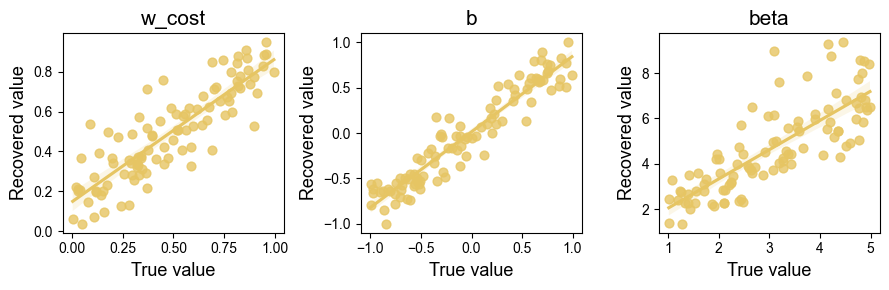

In [16]:
param_names = ['w_cost','b','beta']
n_cols = 3
n_rows = math.ceil(len(param_names)/n_cols)
plt.rcParams['font.family'] = 'Arial'
fig,axes = plt.subplots(n_rows,n_cols,figsize=(9,3*n_rows))
axes = axes.flatten()
for i,name in enumerate(param_names):
    sns.regplot(data = param_rec_df, x = name+'_original', y = name+'_recovered', color = '#e6c563', scatter_kws={'s':40},ax=axes[i])
    pearson_r = np.corrcoef(param_rec_df[name+'_original'],param_rec_df[name+'_recovered'])[0,1]
    axes[i].set_xlabel('True value',size=13)
    axes[i].set_ylabel('Recovered value',size=13)
    axes[i].set_title(name,size=15)

plt.tight_layout()
plt.show()

# Figure 6: Helping ~ Personality Traits

In [82]:
# Individual differences data
Survey1 = Task1_filtered.merge(trait_all,on='PROLIFIC_PID')
trait_merge = pd.read_csv('data/Individual_differences_allvars.csv',index_col=0)

C:\Users\v0409128\AppData\Local\Temp\ipykernel_29624\3040282943.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Dispositional Empathy','Social Value Orientation','Reward Responsiveness','Behavioral Inhibition','Agreeableness'], rotation=30, ha='right', size = 12)


Text(0, 0.5, 'Willingness To Help')

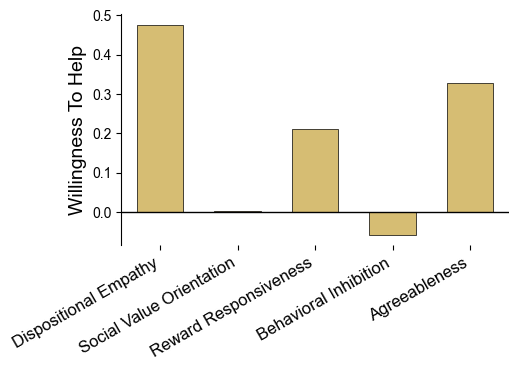

In [74]:
## 6a: WTH ~ Traits
WTH_trait = Survey1[['Mean','IRI_EC','IRI_F','IRI_PD','IRI_PT','SVO_degree','RR_total','BIS_total','BFI_E','BFI_A','BFI_C','BFI_N','BFI_O']].corr()
WTH_trait_input = WTH_trait.loc[['Mean'],['IRI_EC','SVO_degree','RR_total','BIS_total','BFI_A']]

fig,ax = plt.subplots(figsize=(5,3))
sns.barplot(WTH_trait_input, color='#e6c563',edgecolor='black',width=0.6, linewidth=0.5, ax=ax)
ax.set_xticklabels(['Dispositional Empathy','Social Value Orientation','Reward Responsiveness','Behavioral Inhibition','Agreeableness'], rotation=30, ha='right', size = 12)
ax.spines['top'].set_visible(False)
ax.axhline(0,color='black',lw=1)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Willingness To Help',size=14)

In [77]:
# empathy
r_empathy_WTH,p_empathy_WTH = pearsonr(Survey1['IRI_EC'], Task1_filtered['Mean'])
ci_empathy_WTH = pg.compute_bootci(Survey1['IRI_EC'], Task1_filtered['Mean'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_empathy_WTH,p_empathy_WTH*5,ci_empathy_WTH

(0.4757690228318473, 7.617052579085943e-13, array([0.3433, 0.5981]))

In [78]:
# RR
r_RR_WTH,p_RR_WTH = pearsonr(Survey1['RR_total'], Task1_filtered['Mean'])
ci_RR_WTH = pg.compute_bootci(Survey1['RR_total'], Task1_filtered['Mean'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_RR_WTH,p_RR_WTH*5,ci_RR_WTH

(0.21154874131689044, 0.00906684514950449, array([0.0715, 0.3408]))

In [79]:
# BFI-A
r_BFIA_WTH,p_BFIA_WTH = pearsonr(Survey1['BFI_A'], Task1_filtered['Mean'])
ci_BFIA_WTH = pg.compute_bootci(Survey1['BFI_A'], Task1_filtered['Mean'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_BFIA_WTH,p_BFIA_WTH*5,ci_BFIA_WTH

(0.32889665280292013, 4.061886656890547e-06, array([0.1981, 0.4426]))

## 6b: w_cost ~ BIS

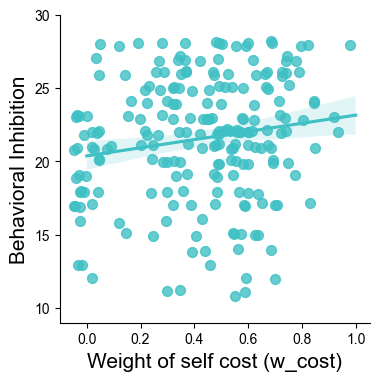

In [83]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4,4))
#plt.scatter(trait_merge['w_cost'],trait_merge['BIS_total'],alpha = 0.6,s=60, color = '#3fc0c4')
sns.regplot(data = trait_merge, x = 'w_cost', y = 'BIS_total', y_jitter=0.2, x_jitter=0.05, color = '#3fc0c4', scatter_kws={'s':50})
plt.xlabel('Weight of self cost (w_cost)',size=15)
plt.ylabel('Behavioral Inhibition',size=15)
plt.ylim([9,30])
plt.yticks([10,15,20,25,30])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [84]:
r_BIS_wcost,p_BIS_wcost = pearsonr(trait_merge['w_cost'], trait_merge['BIS_total'])
ci_BIS_wcost = pg.compute_bootci(trait_merge['w_cost'], trait_merge['BIS_total'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_BIS_wcost,p_BIS_wcost,ci_BIS_wcost

(0.16346936550192842, 0.016434580225178297, array([0.0467, 0.2967]))

## 6c: w_cost ~ RR

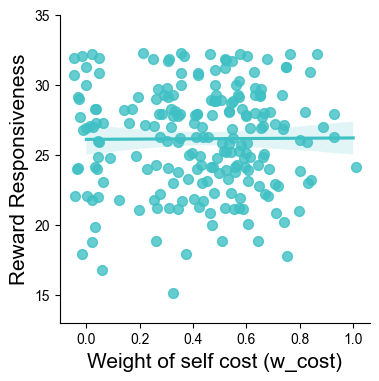

In [85]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4,4))
sns.regplot(data = trait_merge, x = 'w_cost', y = 'RR_total', y_jitter=0.3, x_jitter=0.05, color = '#3fc0c4', scatter_kws={'s':50})
plt.xlabel('Weight of self cost (w_cost)',size=15)
plt.ylabel('Reward Responsiveness',size=15)
plt.ylim([13,35])
plt.yticks([15,20,25,30,35])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [86]:
r_RR_wcost,p_RR_wcost = pearsonr(trait_merge['w_cost'], trait_merge['RR_total'])
ci_RR_wcost = pg.compute_bootci(trait_merge['w_cost'], trait_merge['RR_total'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_RR_wcost,p_RR_wcost,ci_RR_wcost

(0.00676167734624125, 0.9214806418620335, array([-0.1217,  0.1437]))

## 6d: b ~ IRI_EC

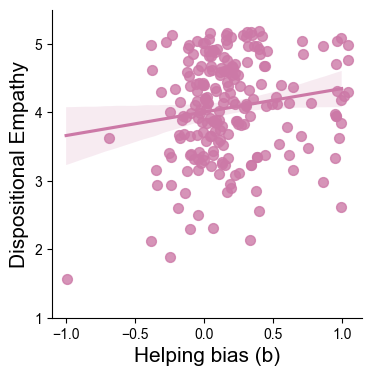

In [87]:
trait_merge['b_flip'] = trait_merge['b']*(-1) # flip the b so the interpretation is more straightforward

plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4,4))
sns.regplot(data = trait_merge, x = 'b_flip', y = 'IRI_EC', y_jitter=0.2, x_jitter=0.05, color = '#cc79a7', scatter_kws={'s':50})
plt.xlabel('Helping bias (b)',size=15)
plt.ylabel('Dispositional Empathy',size=15)
plt.ylim([1, 5.5])
plt.yticks([1,2,3,4,5])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [88]:
r_b_IRIEC,p_b_IRIEC = pearsonr(trait_merge['b_flip'], trait_merge['IRI_EC'])
ci_b_IRIEC = pg.compute_bootci(trait_merge['b_flip'], trait_merge['IRI_EC'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_b_IRIEC,p_b_IRIEC,ci_b_IRIEC

(0.15847834835518845, 0.02007654859622699, array([0.0045, 0.298 ]))

## 6e: b ~ BFI-A

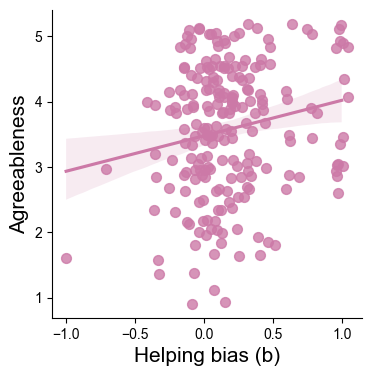

In [89]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(4,4))
sns.regplot(data = trait_merge, x = 'b_flip', y = 'BFI_A', y_jitter=0.2, x_jitter=0.05, color = '#cc79a7', scatter_kws={'s':50})
plt.xlabel('Helping bias (b)',size=15)
plt.ylabel('Agreeableness',size=15)
#plt.ylim([1, 5.5])
#plt.yticks([1,2,3,4,5])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [90]:
r_b_BFIA,p_b_BFIA = pearsonr(trait_merge['b_flip'], trait_merge['BFI_A'])
ci_b_BFIA = pg.compute_bootci(trait_merge['b_flip'], trait_merge['BFI_A'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_b_BFIA,p_b_BFIA,ci_b_BFIA

(0.1828215121124164, 0.007193463050340575, array([0.0511, 0.3024]))

# Hierarchical clustering

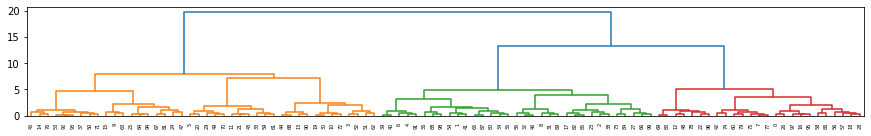

In [11]:
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster

# Hierarchical clustering
distance_reduced = pairwise_distances(data_3spec[['Semantic_x','Semantic_y']], metric='euclidean')

condensed_dist_matrix = squareform(np.round(distance_reduced,5))
Z = linkage(condensed_dist_matrix, method='ward')  # You can change the method (e.g., 'complete', 'average')


# print various layers of hierarchy

hier_labels = pd.DataFrame({'Scenario':data_3spec.index })
hier_labels['thres_2_17'] = fcluster(Z, 2.17, criterion='distance')
hier_labels['thres_5'] = fcluster(Z, 5, criterion='distance')
hier_labels['thres_10'] = fcluster(Z, 10, criterion='distance')
hier_labels.set_index('Scenario',inplace=True)

# Plot the dendrogram

plt.figure(figsize=(15,2))
dendrogram(Z,color_threshold=10)
plt.show()



In [12]:
hier_labels.to_csv('output/Semantic_space_label/hier_clustering_labels.csv')

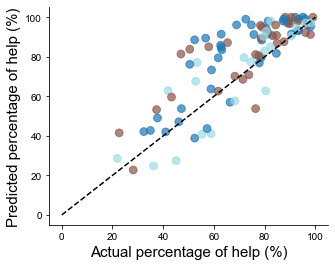

In [47]:
scenario_pred = pred_allsub_df_m3.groupby('Scenario')[['Decision','Pred_choice']].mean()
scenario_pred = scenario_pred.merge(data_3spec, left_on='Scenario', right_index = True)
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(5,4))
plt.plot([0,100],[0,100],color='black',ls='--')
plt.scatter(scenario_pred['Decision']*100,scenario_pred['Pred_choice']*100,alpha = 0.7,s=60, c= hier_labels['thres_10'],cmap="tab20")
plt.xlabel('Actual percentage of help (%)',size=15)
plt.ylabel('Predicted percentage of help (%)',size=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

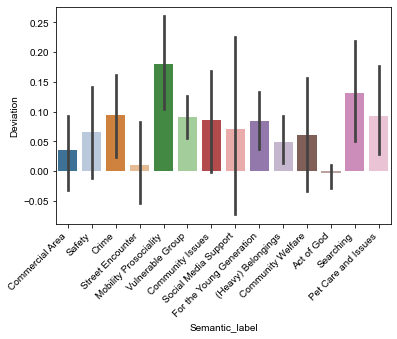

In [54]:
scenario_pred['Deviation'] = scenario_pred['Pred_choice'] - scenario_pred['Decision']

sns.barplot(x=data_3spec['Semantic_label'], y=scenario_pred['Deviation'],saturation=0.6,palette="tab20")
plt.xticks(rotation=45,ha='right') 
plt.show()

In [36]:
data_3spec

,Scenario,Action,Label,Decision_x,Decision_y,WTH,Motivation_reward,Motivation_cost,Motivation_label,Semantic_x,Semantic_y,Semantic_label,label_numeric
S1,You are doing your weekly grocery shopping in ...,This person needs someone to grab the tomato p...,grab high item,-1.765045,1.514770,3.730769,-0.145094,-2.455841,3,2.153924,4.157400,Commercial Area,2
S2,"Sunday, 1am - You were having a very nice drin...","To help the drunk man, someone needs to stay h...",report a drunk person,1.349625,-0.961086,0.067961,-0.944945,1.390401,1,5.796814,3.370692,Safety,9
S3,9pm - You arrive early to meet with a friend a...,"To reduce loss of the house owner, you can rep...",witness thief,0.366823,1.434196,2.154639,0.890838,-0.239670,4,4.683960,4.114389,Crime,5
S4,You are walking in the city center. Waiting fo...,The person needs to use someone's phone for 10...,lend phone,2.087646,-3.272560,-2.301887,-1.763357,-0.357930,3,3.915755,5.882032,Street Encounter,12
S5,You just finish shopping and head to the parki...,"To help the sedan driver recover lost, the wit...",share testimony,-0.246953,1.744878,3.099010,0.586377,-0.502944,4,4.263305,2.603460,Mobility Prosociality,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S96,"While driving through a residential area, you ...",The person hopes a passer-by can stop and giv...,give a spare bag,-1.018359,0.158228,1.912621,-0.014310,-0.906991,3,2.678818,3.680307,(Heavy) Belongings,0
S97,You are in a building to conduct some business...,The person wants someone to hold the door for ...,open a heavy door,-1.696070,2.285102,4.102804,0.191878,-2.138400,4,2.932632,2.578793,(Heavy) Belongings,0
S98,"While walking down the street, you notice a pe...",It will be helpful if someone can pick up the ...,pick up can to recycle,0.152320,0.901101,2.106796,-1.087086,-1.323241,3,2.461608,3.910191,Street Encounter,12
S99,You are driving to the airport to catch an imp...,To control the flame and avoid loss of nearby ...,report fire on the way to airport,-0.869422,1.977708,3.457143,1.679752,-0.828944,4,6.108219,2.363449,Safety,9
